In [1]:
import socket, struct, time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import cv2, os, yaml
from ipywidgets import IntProgress
from IPython.display import display
import pandas as pd

import sys
os.chdir('/home/sen/Documents/Track-Anything')
sys.path.append("/home/sen/Documents/Track-Anything/tracker")
sys.path.append("/home/sen/Documents/Track-Anything/tracker/model")
from track_anything import TrackingAnything_2
from track_anything import parse_augment
import requests,json,torch,torchvision,time  
from tools.painter import mask_painter

In [2]:
folder ="./checkpoints"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"

# initialize sam, xmem, e2fgvi models
args = parse_augment()
model = TrackingAnything_2(xmem_checkpoint, e2fgvi_checkpoint,args)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False


/home/sen/anaconda3/envs/inpaint/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


成功打开索引为 0 的摄像头
成功打开索引为 2 的摄像头
成功打开索引为 4 的摄像头


[ WARN:0@3.405] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ WARN:0@3.525] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:0@3.539] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video5): can't open camera by index


成功打开索引为 6 的摄像头
未能打开任何摄像头


[ WARN:0@3.802] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video7): can't open camera by index
[ WARN:0@3.802] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video8): can't open camera by index
[ WARN:0@3.802] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video9): can't open camera by index


Frame rate is  33.97220175384777
Time cost is  3.532386302947998


(720, 1280, 3)

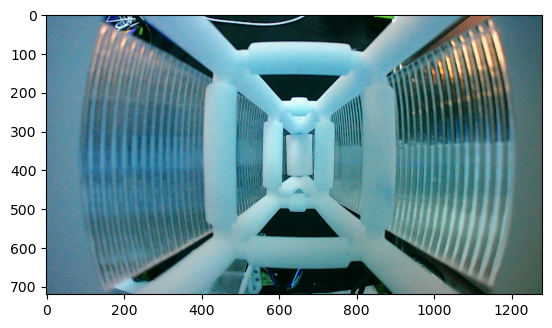

In [3]:
# 循环尝试打开可能的摄像头索引
for index in range(10):  # 假设系统中不会超过10个摄像头
    cap = cv2.VideoCapture(index)
    if cap.isOpened():
        print(f"成功打开索引为 {index} 的摄像头")
        cap.release()
        #break
else:
    print("未能打开任何摄像头")
    
# image_w = 1920
# image_h = 1080
image_w = 1280
image_h = 720
# image_w = 640
# image_h = 360

cap = cv2.VideoCapture(6)
cap.set(3,image_w)
cap.set(4,image_h)
# cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.75) # fixed exposure 0.75, automatic 0.25
# cap.set(cv2.CAP_PROP_EXPOSURE,3) # train 1 and 2 are 0.05, train-3 is 0.1
ret, img = cap.read()
img.shape
#捕获30帧的过程中，计算得出的帧率大约是每秒34.05帧（FPS）。FPS是Frames Per Second（每秒帧数）
t0 = time.time()  
for i in range(120):
    ret, img = cap.read()

print('Frame rate is ', 120/(time.time()-t0))
print('Time cost is ', time.time()-t0)
plt.imshow(img)
img.shape

In [4]:
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"当前相机帧率: {fps} FPS")

# 尝试设置相机帧率为330 FPS
desired_fps = 90.0
cap.set(cv2.CAP_PROP_FPS, desired_fps)

# 检查设置后的帧率
actual_fps = cap.get(cv2.CAP_PROP_FPS)
print(f"尝试设置的帧率: {desired_fps}, 相机实际帧率: {actual_fps}")

当前相机帧率: 120.0 FPS
尝试设置的帧率: 90.0, 相机实际帧率: 120.0


In [5]:
class ATISensor:
    '''The class interface for an ATI Force/Torque sensor.
    This class contains all the functions necessary to communicate
    with an ATI Force/Torque sensor with a Net F/T interface
    using socket.
    '''    
    def __init__(self, ip='192.168.1.1'):
        self.ip = ip
        self.port = 49151
        self.sock = socket.socket()
        time.sleep(0.5) # wait for proper connection
        self.sock.connect((self.ip, self.port))
        self.READ_CALIBRATION_INFO = bytes([0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
                              0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00])
        self.READ_FORCE = bytes([0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
                           0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00])
        self.RESET_FORCE = bytes([0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
                           0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01])
        self.countsPerForce = 1000000
        self.countsPerTorque = 1000000
        self.scaleFactors_force = 15260      # ATI Nano25 of SusTech
        self.scaleFactors_torque = 92
        self.sock.send(self.RESET_FORCE)
    def get_measurement(self):
        self.sock.send(self.READ_FORCE)
        force_info = self.sock.recv(16)
        header, status, ForceX, ForceY, ForceZ, TorqueX, TorqueY, TorqueZ = struct.unpack('!2H6h', force_info)
        raw = np.array([ForceX, ForceY, ForceZ, TorqueX, TorqueY, TorqueZ])
        force_torque = np.concatenate([raw[:3] * self.scaleFactors_force/self.countsPerForce, 
                                 raw[3:] * self.scaleFactors_torque/self.countsPerTorque])
        return force_torque
    
    def reset(self):
        self.sock.send(self.RESET_FORCE)
        
    def close(self):
        self.sock.close()

sensor = ATISensor()
t0 = time.time()
for i in range(1000):
    ft = sensor.get_measurement()

sensor.close()
print("The frequency of ATI is ", 1000/(time.time()-t0))

The frequency of ATI is  858.5942142641179


In [6]:
sensor = ATISensor()
K = 1
N = 10000
f = IntProgress(min=0, max=N) # instantiate the bar
display(f)

fts = np.zeros([N,6])
timestamps = []

for k in range(K):
    images = np.zeros([N, 360, 640,3],dtype=np.uint8)
    sensor.reset()
    print("%s Please press the finger..."%k)
    s = time.time()
    for i in range(N):  #120*60*10)
        timestamps.append(time.time()-s)
        ft = sensor.get_measurement()
        ret, color_image = cap.read()
        images[i,:,:,] = color_image[::2,::2,:]
        fts[i, :] = ft
        f.value = i
    print("Saving images...")
    
sensor.close()

dir = '/home/sen/Documents/Track-Anything/forcesensor/test-23-cam1-' + datetime.now().strftime("%m%d-%H%M%S")
os.mkdir(dir)

for i in range(N):
    cv2.imwrite(dir+'/%s.png'%i,images[i,:,:,:])
np.save(dir+"/force_vecs.npy", fts)
np.save(dir+"/timestamps.npy",timestamps)
print("Save to path, pls update: ", dir)

IntProgress(value=0, max=10000)

0 Please press the finger...
Saving images...
Save to path, pls update:  /home/sen/Documents/Track-Anything/forcesensor/test-23-cam1-0410-232843


[[ 0.0000e+00  0.0000e+00 -1.5260e-02  1.1040e-03  0.0000e+00  0.0000e+00]
 [ 1.5260e-02  0.0000e+00  3.0520e-02 -2.7600e-04  0.0000e+00  9.2000e-05]
 [ 0.0000e+00  0.0000e+00  1.5260e-02  9.2000e-04 -2.7600e-04 -9.2000e-05]
 ...
 [ 1.8312e-01  0.0000e+00 -9.1560e-02 -2.7600e-04  4.6920e-03  2.2080e-03]
 [ 1.6786e-01  0.0000e+00 -1.3734e-01 -1.5640e-03  4.7840e-03  2.3920e-03]
 [ 1.5260e-01  0.0000e+00 -9.1560e-02 -7.3600e-04  5.1520e-03  2.1160e-03]]
size of ATI_data: (10000, 6)
size of timestamps: (10000,)


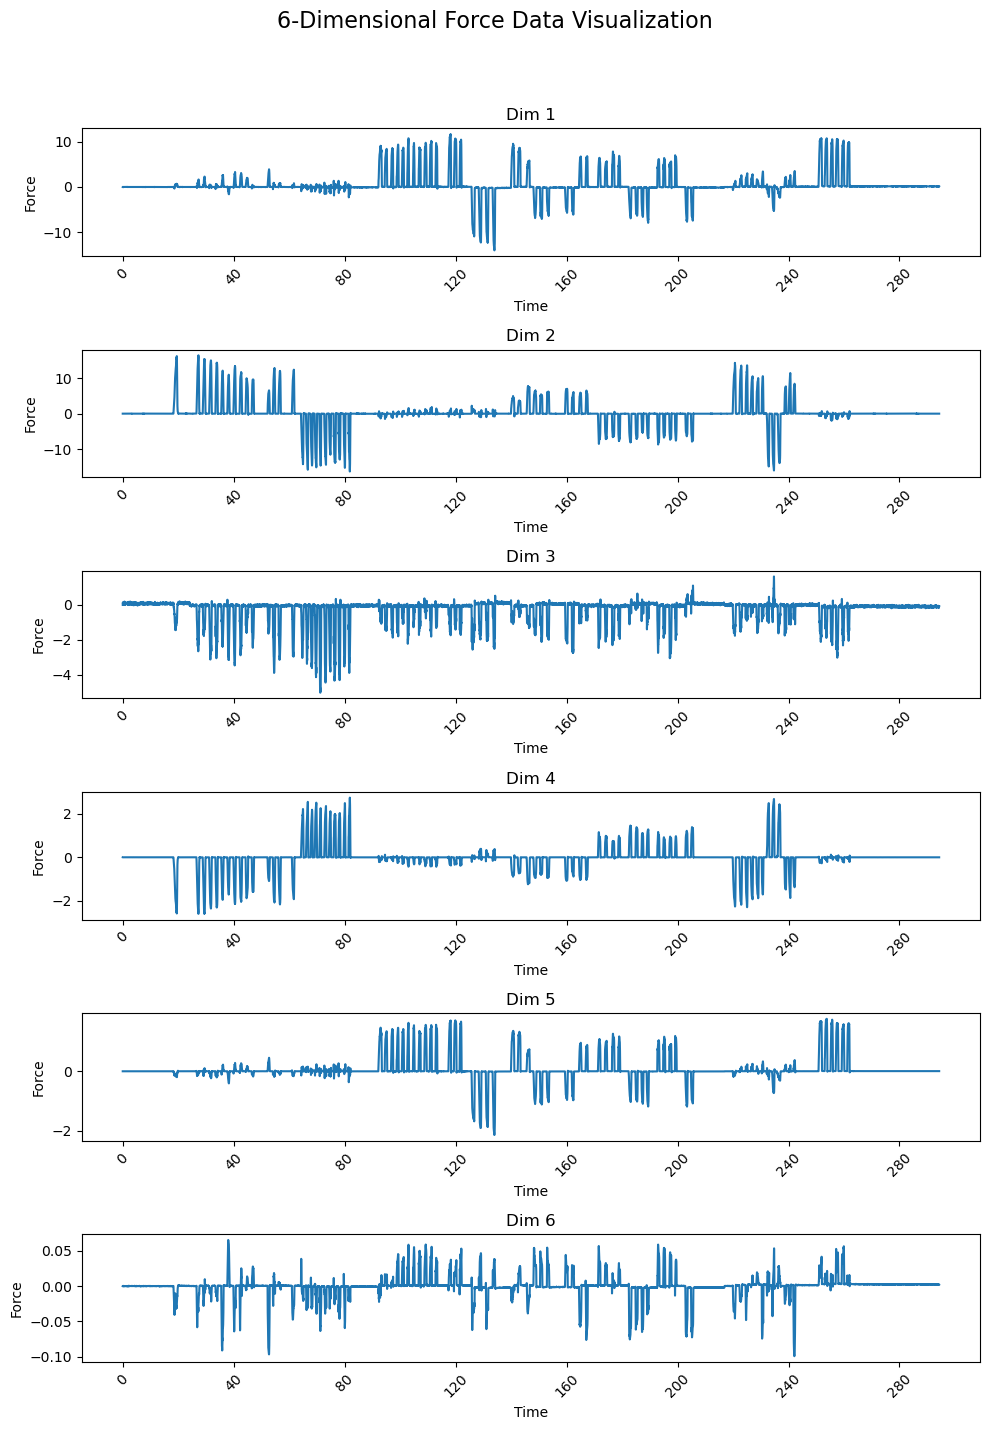

Save to path, pls update:  /home/sen/Documents/Track-Anything/forcesensor/test-23-cam1-0410-232843


In [7]:
# 文件路径
file_path = dir+'/force_vecs.npy'
timestamp_file_path = dir+'/timestamps.npy'  # 时间戳数据文件路径

# 读取.npy文件
ATI_data = np.load(file_path)

# 显示数据
print(ATI_data)

print("size of ATI_data:", ATI_data.shape)
timestamps = np.load(timestamp_file_path) 
print("size of timestamps:", timestamps.shape)

#timestamps = [datetime.fromtimestamp(ts) for ts in timestamps]


# 假设ATI_data是你已经加载的数组
# ATI_data = np.load(file_path)

# 创建一个图形和6个子图，每行一个
fig, axs = plt.subplots(6, 1, figsize=(10, 15))

# 设置整体图形的标题
fig.suptitle('6-Dimensional Force Data Visualization', fontsize=16)

# 维度标签
dimension_labels = ['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4', 'Dim 5', 'Dim 6']

# 遍历所有维度，为每个维度绘制一个子图
for i in range(6):
    axs[i].plot(timestamps, ATI_data[:, i])
    axs[i].set_title(dimension_labels[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Force')
    # 优化时间轴显示
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(10))  # 限制显示的最大刻度数量
    axs[i].tick_params(axis='x', rotation=45)  # 旋转标签以便阅读

# 调整子图间的布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示图形
plt.show()


print("Save to path, pls update: ", dir)

In [8]:
fig.savefig(datetime.now().strftime("%m%d-%H%M%S") + 'ATI_ForceTau6axis-GroundTruth_0409-160432.png', dpi=300)